In [1]:
# create a three layer MLP in torch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm

# auto reload modules when they change
%load_ext autoreload
%autoreload 2

from causal_networks.dag import DeterministicDAG

In [2]:
# create a three layer MLP in torch
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size, bias=True)
        self.layer2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.layer3 = nn.Linear(hidden_size, output_size, bias=True)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.softmax(self.layer3(x))
        return x




In [3]:
def generate_grouped_data(n):
    """Generates n data points with 4 balanced groups,
       (w==x, y==z), (w==x, y!=z), (w!=x, y==z), (w!=x, y!=z)
       For the heirarchical equality task""" 
    
    # Initialize the empty list for data and labels
    data, labels = [], []
    for i in range(n):
        # Define a pattern for each group based on the remainder when i is divided by 4
        group_pattern = i % 4
        
        # Depending on the pattern, generate w, x, y, z
        if group_pattern == 0:  # w==x, y!=z
            w = x = np.random.uniform(-0.5, 0.5)
            y, z = np.random.uniform(-0.5, 0.5, 2)
        elif group_pattern == 1:  # w==x, y==z
            w = x = np.random.uniform(-0.5, 0.5)
            y = z = np.random.uniform(-0.5, 0.5)
        elif group_pattern == 2:  # w!=x, y==z
            w, x = np.random.uniform(-0.5, 0.5, 2)
            y = z = np.random.uniform(-0.5, 0.5)
        elif group_pattern == 3:  # w!=x, y!=z
            w, x, y, z = np.random.uniform(-0.5, 0.5, 4)
        
        # Decide the label based on the given condition
        label = 1 if (w == x) == (y == z) else 0

        # Append the generated data and label to the respective lists
        data.append([w, x, y, z])
        labels.append(label)

    # Convert the lists to numpy arrays for further processing
    data = np.array(data)
    labels = np.array(labels)

    return data, labels


In [4]:
# generate the data
data, labels = generate_grouped_data(100000)

In [5]:
# train the network

# set the random seed
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# define the hyperparameters
input_size = 4
hidden_size = 16
output_size = 2
num_epochs = 10000
batch_size = 10
learning_rate = 0.01

# define the model
model = MLP(input_size, hidden_size, output_size)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1000, verbose=True)

# convert the data and labels to torch tensors
data, labels = generate_grouped_data(100000)
data = torch.from_numpy(data).float()
labels = torch.from_numpy(labels).long()

val_data, val_labels = generate_grouped_data(100)
val_data = torch.from_numpy(val_data).float()
val_labels = torch.from_numpy(val_labels).long()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = data.to(device)
labels = labels.to(device)
val_data = val_data.to(device)
val_labels = val_labels.to(device)
model = model.to(device)

# train the model
for epoch in range(num_epochs):
    # forward pass
    outputs = model(data)
    loss = criterion(outputs, labels)
    
    # backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    if (epoch+1) % 100 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# test the model
with torch.no_grad():
    # forward pass
    outputs = model(val_data)
    _, predicted = torch.max(outputs.data, 1)

    # compute the accuracy
    total = val_labels.size(0)
    correct = (predicted == val_labels).sum().item()
    print('Accuracy of the network on the 100 test data: {} %'.format(100 * correct / total))

Epoch [100/10000], Loss: 0.5619
Epoch [200/10000], Loss: 0.4240
Epoch [300/10000], Loss: 0.3928
Epoch [400/10000], Loss: 0.3798
Epoch [500/10000], Loss: 0.3739
Epoch [600/10000], Loss: 0.3634
Epoch [700/10000], Loss: 0.3567
Epoch [800/10000], Loss: 0.3609
Epoch [900/10000], Loss: 0.3488
Epoch [1000/10000], Loss: 0.3642
Epoch [1100/10000], Loss: 0.3560
Epoch [1200/10000], Loss: 0.3429
Epoch [1300/10000], Loss: 0.3414
Epoch [1400/10000], Loss: 0.3406
Epoch [1500/10000], Loss: 0.3404
Epoch [1600/10000], Loss: 0.3396
Epoch [1700/10000], Loss: 0.3382
Epoch [1800/10000], Loss: 0.3371
Epoch [1900/10000], Loss: 0.3361
Epoch [2000/10000], Loss: 0.3368
Epoch [2100/10000], Loss: 0.3442
Epoch [2200/10000], Loss: 0.3583
Epoch [2300/10000], Loss: 0.3481
Epoch [2400/10000], Loss: 0.3327
Epoch [2500/10000], Loss: 0.3337
Epoch [2600/10000], Loss: 0.3315
Epoch [2700/10000], Loss: 0.3634
Epoch [2800/10000], Loss: 0.3322
Epoch [2900/10000], Loss: 0.3310
Epoch [3000/10000], Loss: 0.3391
Epoch [3100/10000],

## Causal DAGS

In [6]:
def float_validator(value):
    return -0.5 <= value <= 0.5

def float_sampler():
    return random.uniform(-0.5, 0.5)

def bool_validator(value):
    return value in {True, False}

def bool_sampler():
    return random.choice([True, False])

def copy_func(x):
    return x

def compare_func(value1, value2):
    return value1 == value2

dag = DeterministicDAG()

# Define the nodes
dag.add_node('x1', validator=float_validator, sampler=float_sampler)
dag.add_node('x2', validator=float_validator, sampler=float_sampler)
dag.add_node('x3', validator=float_validator, sampler=float_sampler)
dag.add_node('x4', validator=float_validator, sampler=float_sampler)
dag.add_node('c1', func=copy_func, validator=float_validator, sampler=float_sampler)
dag.add_node('c2', func=copy_func, validator=float_validator, sampler=float_sampler)
dag.add_node('c3', func=copy_func, validator=float_validator, sampler=float_sampler)
dag.add_node('c4', func=copy_func, validator=float_validator, sampler=float_sampler)
dag.add_node('b1', func=compare_func, validator=bool_validator, sampler=bool_sampler)
dag.add_node('b2', func=compare_func, validator=bool_validator, sampler=bool_sampler)
dag.add_node('y', func=compare_func, validator=bool_validator, sampler=bool_sampler)

# Define the edges
edges = [('x1', 'c1'), ('x2', 'c2'), ('x3', 'c3'), ('x4', 'c4'), 
         ('c1', 'b1'), ('c2', 'b1'), ('c3', 'b2'), ('c4', 'b2'), 
         ('b1', 'y'), ('b2', 'y')]
for edge in edges:
    dag.add_edge(*edge)


dag.set_inputs(x1=0.1, x2=0.2, x3=0.3, x4=0.4)

dag.run_inputs()

# print out all values
for node in dag.G.nodes:
    print(f"{node}: {dag.get_value(node)}")


import random
num_iterations = 100

for _ in range(num_iterations):
    # Select a node at random and perform a random intervention
    node = random.choice(list(dag.G.nodes))
    value = dag.samplers[node]()

    # reset all interventions
    dag.reset_interventions()

    dag.intervene(node, value)

    # Set input values
    input_values = {node: dag.samplers[node]() for node in dag.get_roots()}
    dag.set_inputs(**input_values)

    # Run the DAG
    dag.run_inputs()

    # Get the values of all nodes
    node_values = {node: dag.get_value(node) for node in dag.G.nodes}
    print(node_values)



x1: 0.1
x2: 0.2
x3: 0.3
x4: 0.4
c1: 0.1
c2: 0.2
c3: 0.3
c4: 0.4
b1: False
b2: False
y: True
{'x1': -0.079428419169155, 'x2': -0.24108324970703665, 'x3': 0.01127472136860852, 'x4': -0.09506586254958571, 'c1': 0.1, 'c2': 0.2, 'c3': 0.2579544029403025, 'c4': 0.4, 'b1': False, 'b2': False, 'y': True}
{'x1': -0.14195062530501168, 'x2': 0.39166065982068243, 'x3': -0.2815572730847683, 'x4': -0.36072629480184737, 'c1': 0.46779999492017144, 'c2': 0.2, 'c3': 0.2579544029403025, 'c4': 0.4, 'b1': False, 'b2': False, 'y': True}
{'x1': 0.11836899667533163, 'x2': -0.24949365863755946, 'x3': 0.4097462559682401, 'x4': 0.4827854760376531, 'c1': 0.46779999492017144, 'c2': 0.2, 'c3': 0.4097462559682401, 'c4': 0.4, 'b1': False, 'b2': False, 'y': True}
{'x1': -0.18985243068066737, 'x2': 0.22983174826012864, 'x3': 0.3988382879679935, 'x4': 0.18398393191544127, 'c1': 0.46779999492017144, 'c2': 0.2, 'c3': 0.4097462559682401, 'c4': 0.4, 'b1': False, 'b2': True, 'y': False}
{'x1': -0.14620867048075925, 'x2': -0.

In [7]:
dag.validators['x1'].__code__

<code object float_validator at 0x7f8b82b1e6b0, file "/tmp/ipykernel_36436/1111605037.py", line 1>

In [8]:
dag.get_roots()

['x1', 'x2', 'x3', 'x4']

In [9]:
import platform
import matplotlib
import networkx as nx

print("Python version:", platform.python_version())
print("Matplotlib version:", matplotlib.__version__)
print("NetworkX version:", nx.__version__)


Python version: 3.11.2
Matplotlib version: 3.7.1
NetworkX version: 3.1


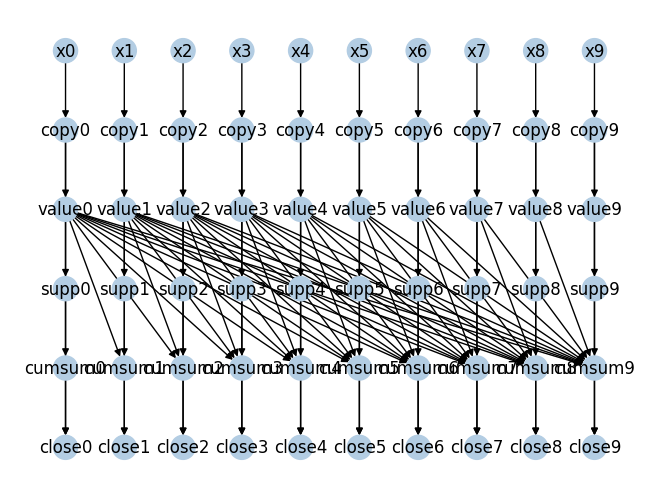

                                     Node Information                                     
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node    ┃ Function           ┃ Sampler               ┃ Validator               ┃ Value ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x0      │ -                  │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ copy0   │ copy_func          │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ value0  │ interp_symbol_func │ interp_symbol_sampler │ interp_symbol_validator │ -     │
│ supp0   │ is_suppressed_func │ bool_sampler          │ bool_validator          │ -     │
│ cumsum0 │ cumsum_func        │ cumsum_sampler        │ cumsum_validator        │ -     │
│ close0  │ close_paren_func   │ bool_sampler          │ bool_validator          │ -     │
│ x1      │ -                  │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ copy1   │ copy_func          │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ value1  │ interp_symbol_func │ interp_symbol_sampler │ interp_symbol_validator │ -     │
│ supp1   │ is_suppressed_func │ bool_sampler          │ bool_validator          │ -     │
│ cumsum1 │ cumsum_func        │ cumsum_sampler        │ cumsum_validator        │ -     │
│ close1  │ close_paren_func   │ bool_sampler          │ bool_validator          │ -     │
│ x2      │ -                  │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ copy2   │ copy_func          │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ value2  │ interp_symbol_func │ interp_symbol_sampler │ interp_symbol_validator │ -     │
│ supp2   │ is_suppressed_func │ bool_sampler          │ bool_validator          │ -     │
│ cumsum2 │ cumsum_func        │ cumsum_sampler        │ cumsum_validator        │ -     │
│ close2  │ close_paren_func   │ bool_sampler          │ bool_validator          │ -     │
│ x3      │ -                  │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ copy3   │ copy_func          │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ value3  │ interp_symbol_func │ interp_symbol_sampler │ interp_symbol_validator │ -     │
│ supp3   │ is_suppressed_func │ bool_sampler          │ bool_validator          │ -     │
│ cumsum3 │ cumsum_func        │ cumsum_sampler        │ cumsum_validator        │ -     │
│ close3  │ close_paren_func   │ bool_sampler          │ bool_validator          │ -     │
│ x4      │ -                  │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ copy4   │ copy_func          │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ value4  │ interp_symbol_func │ interp_symbol_sampler │ interp_symbol_validator │ -     │
│ supp4   │ is_suppressed_func │ bool_sampler          │ bool_validator          │ -     │
│ cumsum4 │ cumsum_func        │ cumsum_sampler        │ cumsum_validator        │ -     │
│ close4  │ close_paren_func   │ bool_sampler          │ bool_validator          │ -     │
│ x5      │ -                  │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ copy5   │ copy_func          │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ value5  │ interp_symbol_func │ interp_symbol_sampler │ interp_symbol_validator │ -     │
│ supp5   │ is_suppressed_func │ bool_sampler          │ bool_validator          │ -     │
│ cumsum5 │ cumsum_func        │ cumsum_sampler        │ cumsum_validator        │ -     │
│ close5  │ close_paren_func   │ bool_sampler          │ bool_validator          │ -     │
│ x6      │ -                  │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ copy6   │ copy_func          │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ value6  │ interp_symbol_func │ interp_symbol_sampler │ interp_symbol_validator │ -     │
│ supp6   │ is_suppressed_func │ bool_sampler          │ bool_validator          │ -   

In [13]:

# implement the paren balancing task

dag = DeterministicDAG()

def convert_token_to_DAG_input(token):
    """
    Converts a token to a DAG input.
    """
    if token == '(':
        return '('
    elif token == ')':
        return ')'
    # else if token is _ or ' or + or - then return S
    elif token in {'_', "'", '+', '-'}:
        return 'S'
    else:
        return '0'
    

def input_symbol_validator(symbol):
    """
    Checks if a symbol is a valid input symbol.
    it should be ( ) _ ' + - S or 0
    """
    return symbol in {'(', ')', 'S', '0'}


def input_symbol_sampler():
    """
    Samples a random input symbol.
    """
    return random.choice(['(', ')', 'S', '0'])

def interp_symbol_validator(symbol):
    """
    Checks if a symbol is a valid interp symbol.
    it should be ( ) _ ' + - S or 0
    """
    return symbol in {1, -1, 0}

def interp_symbol_sampler():
    """
    Samples a random interp symbol.
    """
    return random.choice([1, -1, 0])

def bool_validator(value):
    return value in {True, False}

def bool_sampler():
    return random.choice([True, False])


def copy_func(x):
    return x

def compare_func(value1, value2):
    return value1 == value2


def cumsum_func(*x):
    return sum(x)

def cumsum_validator(value):
    # make sure its an int
    return isinstance(value, int)

def cumsum_sampler():
    return random.randint(0, 2)

def interp_symbol_func(x):
    if x == '(':
        return 1
    elif x == ')':
        return -1
    else:
        return 0
    
def is_suppressed_func(x):
    if x == 'S' or x == '(':
        return True
    else:
        return False
    
def close_paren_func(cumsum, is_suppressed):
    if cumsum > 0 and is_suppressed:
        return True
    else:
        return False

# Define the nodes
context_length = 10

for i in range(context_length):
    dag.add_node(f'x{i}', validator=input_symbol_validator, sampler=input_symbol_sampler, subset=i)
    dag.add_node(f'copy{i}', func=copy_func, validator=input_symbol_validator, sampler=input_symbol_sampler, subset=i)
    dag.add_node(f'value{i}', func=interp_symbol_func, validator=interp_symbol_validator, sampler=interp_symbol_sampler, subset=i)
    dag.add_node(f'supp{i}', func=is_suppressed_func, validator=bool_validator, sampler=bool_sampler, subset=i)
    dag.add_node(f'cumsum{i}', func=cumsum_func, validator=cumsum_validator, sampler=cumsum_sampler, subset=i)
    dag.add_node(f'close{i}', func=close_paren_func, validator=bool_validator, sampler=bool_sampler, subset=i)

# connect each x_i to copy_i
for i in range(context_length):
    dag.add_edge(f'x{i}', f'copy{i}')
    # connect each copy_i to value_i
    dag.add_edge(f'copy{i}', f'value{i}')
    # connect each copy_i to supp_i
    dag.add_edge(f'copy{i}', f'supp{i}')
    # connect each value_i with i <= j to cumsum_j
    for j in range(i+1):
        dag.add_edge(f'value{j}', f'cumsum{i}')
    # connect each cumsum_i to close_paren_i
    dag.add_edge(f'cumsum{i}', f'close{i}')
    # connect each supp_i to close_paren_i
    dag.add_edge(f'supp{i}', f'close{i}')

dag.visualize()


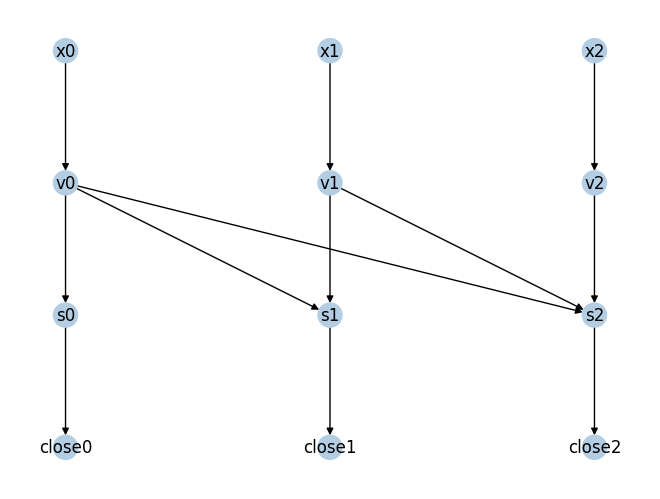

                                    Node Information                                     
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node   ┃ Function           ┃ Sampler               ┃ Validator               ┃ Value ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x0     │ -                  │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ v0     │ interp_symbol_func │ interp_symbol_sampler │ interp_symbol_validator │ -     │
│ s0     │ cumsum_func        │ cumsum_sampler        │ cumsum_validator        │ -     │
│ close0 │ close_paren_func   │ bool_sampler          │ bool_validator          │ -     │
│ x1     │ -                  │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ v1     │ interp_symbol_func │ interp_symbol_sampler │ interp_symbol_validator │ -     │
│ s1     │ cumsum_func        │ cumsum_sampler        │ cumsum_validator        │ -     │
│ close1 │ close_paren_func   │ bool_sampler          │ bool_validator          │ -     │
│ x2     │ -                  │ input_symbol_sampler  │ input_symbol_validator  │ -     │
│ v2     │ interp_symbol_func │ interp_symbol_sampler │ interp_symbol_validator │ -     │
│ s2     │ cumsum_func        │ cumsum_sampler        │ cumsum_validator        │ -     │
│ close2 │ close_paren_func   │ bool_sampler          │ bool_validator          │ -     │
└────────┴────────────────────┴───────────────────────┴─────────────────────────┴───────┘

In [8]:

# implement the paren balancing task

dag = DeterministicDAG()

def convert_token_to_DAG_input(token):
    """
    Converts a token to a DAG input.
    """
    if token == '(':
        return '('
    elif token == ')':
        return ')'
    # else if token is _ or ' or + or - then return S
    elif token in {'_', "'", '+', '-'}:
        return 'S'
    else:
        return '0'
    

def input_symbol_validator(symbol):
    """
    Checks if a symbol is a valid input symbol.
    it should be ( ) _ ' + - S or 0
    """
    return symbol in {'(', ')', 'S', '0'}


def input_symbol_sampler():
    """
    Samples a random input symbol.
    """
    return random.choice(['(', ')', 'S', '0'])

def interp_symbol_validator(symbol):
    """
    Checks if a symbol is a valid interp symbol.
    it should be ( ) _ ' + - S or 0
    """
    return symbol in {1, -1, 0}

def interp_symbol_sampler():
    """
    Samples a random interp symbol.
    """
    return random.choice([1, -1, 0])

def bool_validator(value):
    return value in {True, False}

def bool_sampler():
    return random.choice([True, False])


def copy_func(x):
    return x

def compare_func(value1, value2):
    return value1 == value2


def cumsum_func(*x):
    return sum(x)

def cumsum_validator(value):
    # make sure its an int
    return isinstance(value, int)

def cumsum_sampler():
    return random.randint(0, 2)

def interp_symbol_func(x):
    if x == '(':
        return 1
    elif x == ')':
        return -1
    else:
        return 0
    
def is_suppressed_func(x):
    if x == 'S' or x == '(':
        return True
    else:
        return False
    
def close_paren_func(cumsum):
    if cumsum > 0:
        return True
    else:
        return False

# Define the nodes
context_length = 3

for i in range(context_length):
    dag.add_node(f'x{i}', validator=input_symbol_validator, sampler=input_symbol_sampler, subset=i)
    dag.add_node(f'v{i}', func=interp_symbol_func, validator=interp_symbol_validator, sampler=interp_symbol_sampler, subset=i)
    dag.add_node(f's{i}', func=cumsum_func, validator=cumsum_validator, sampler=cumsum_sampler, subset=i)
    dag.add_node(f'close{i}', func=close_paren_func, validator=bool_validator, sampler=bool_sampler, subset=i)

# connect each x_i to copy_i
for i in range(context_length):
    dag.add_edge(f'x{i}', f'v{i}')
    # connect each value_i with i <= j to cumsum_j
    for j in range(i+1):
        dag.add_edge(f'v{j}', f's{i}')
    # connect each cumsum_i to close_paren_i
    dag.add_edge(f's{i}', f'close{i}')

dag.visualize()
